In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle 
import sys
import gym
import torch
import pandas as pd

sys.path.append('../modules/')
from Agents.RepresentationLearning import PlaceCells
from Utils.gridworld_plotting import *
from Utils import one_hot_state
sys.path.append('../../')## add basic so torch can load agent


# make policy and value arrays
def snapshot(sample_states, observations):
    # initialize empty data frames
    pol_grid = np.zeros(env.shape, dtype=[(x, 'f8') for x in env.action_list])
    val_grid = np.empty(env.shape)

    mem_grid = np.zeros(env.shape, dtype=[(x, 'f8') for x in env.action_list])

    # forward pass through network
    pols, vals = network(observations)

    # populate with data from network
    for s, p, v in zip(sample_states, pols, vals):
        pol_grid[s] = tuple(p.data.numpy())
        val_grid[s] = v.item()

    
    return pol_grid, val_grid

In [2]:
df = pd.read_csv('../Data/mf_training.csv')

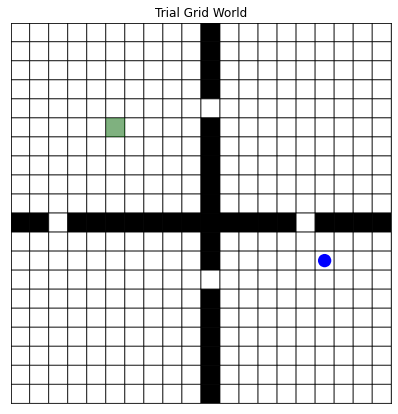

using PC rep
Field Size is 0.1


In [3]:
agent_id = '43027cdd-8361-44a5-9cf7-c8463addb11a'

# get row of data frame with details of run
details = df.loc[df['run_id']==agent_id]

# reconstruct env
env_id = details['env_type'].values[0]
env = gym.make(env_id)
plt.show()

# reconstruct agent  
network = torch.load(f'../Data/agents/{agent_id}.pt')
with open(f'../Data/results/{agent_id}_data.p', 'rb') as f:
    data = pickle.load(f)
    
state_reps = {}
if 'place_cells' in data.keys():
    print('using PC rep')
    num_cells = details['Num_inputs'].values[0]
    place_cell_field_size = details['PlaceCell_fieldsize'].values[0]
    print(f'Field Size is {place_cell_field_size}')
    place_cell_centres = data['place_cells']
    place_cells = PlaceCells(env.shape, num_cells=int(num_cells), cell_centres =place_cell_centres, field_size=place_cell_field_size)
    for state in env.useable:
        state_reps[env.twoD2oneD(state)] = place_cells.get_activities([state])
else:
    for state in env.useable:
        state_reps[env.twoD2oneD(state)]= one_hot_state(env, env.twoD2oneD(state))

In [4]:
sample_states = [env.oneD2twoD(s) for s in list(state_reps.keys())]
if 'place_cells' in data.keys():
    observations = [rep[0] for rep in list(state_reps.values())]
else:
    observations = list(state_reps.values())
p, v = snapshot(sample_states, observations)

p,v = data['P_snap'][-1], data['V_snap'][-1]

IndexError: list index out of range

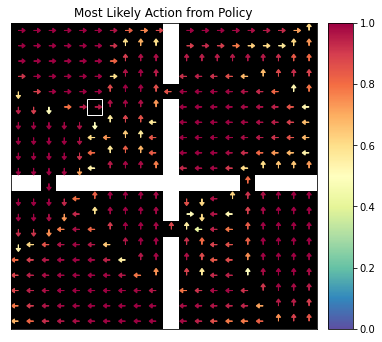

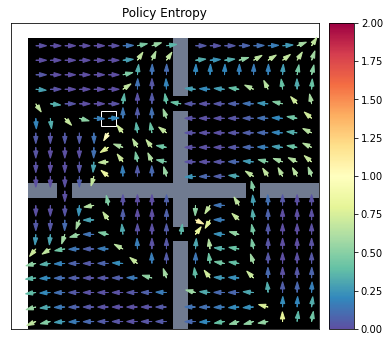

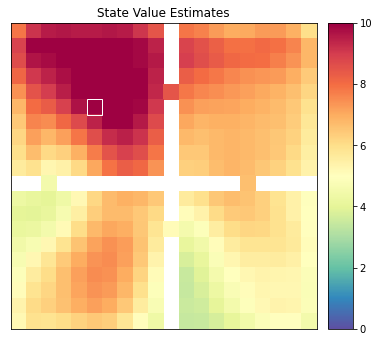

In [5]:
plot_polmap(env,p)
plot_pref_pol(env,p)
plot_valmap(env,v, v_range=[0,10])

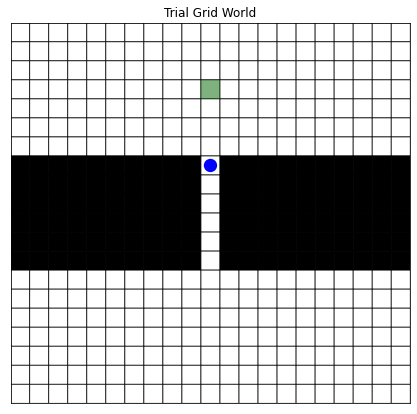

In [25]:
# load in sr matrix
env_id = 'gym_grid:gridworld-v5'
env = gym.make(env_id)
with open(f'../modules/Agents/RepresentationLearning/SR_{env_id}.p', 'rb') as f:
    sr_ = pickle.load(f)

state_reps = {}
SR = np.sum(sr_, axis = 0)
for index in range(SR.shape[0]):
    state_reps[index] = SR[index]

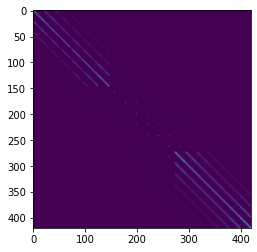

In [26]:
plt.figure()
plt.imshow(SR)
plt.show()

In [8]:
place_cell_centres.shape
cell_centres = np.zeros((400,2))
for i in range(env.nstates):
    cell_centres[i] = np.multiply(env.oneD2twoD(i), (1/env.shape[0], 1/env.shape[1]))
#print(place_cell_centres)
pcs_ = PlaceCells(env.shape, num_cells= 400, cell_centres=cell_centres, field_size=1/env.shape[0])

plt.figure()
plt.imshow(pcs_.get_activities([(0,9)]), aspect='auto')
plt.show()



IndexError: index 400 is out of bounds for axis 0 with size 400

In [16]:
act= pcs_.get_activities(env.useable)[:,9]
print(np.argmax(pcs_.get_activities([(0,9)])))
print(env.oneD2twoD(180))
xs = [x[0] for x in env.useable]
ys = [x[1] for x in env.useable]
plt.scatter(ys, xs, c=act)
plt.axis('equal')
plt.gca().invert_yaxis()

NameError: name 'pcs_' is not defined

In [76]:

state_reps = {}
for state in env.useable:
    state_reps[env.twoD2oneD(state)] = pcs_.get_activities([state])
    

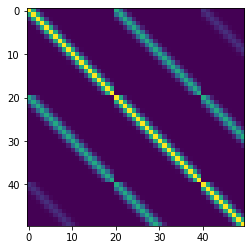

In [77]:
PC = np.zeros((env.nstates, env.nstates))
for i in [env.twoD2oneD(x) for x in env.useable]:
    PC[i] = state_reps[i]
    
plt.figure()
plt.imshow(PC[0:50,0:50])
plt.show()

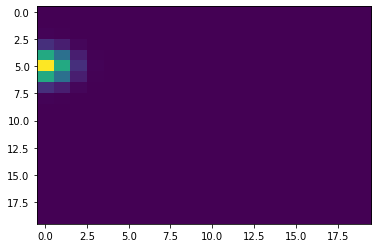

In [78]:
plt.figure()
plt.imshow(PC[:,100].reshape(20,20), aspect='auto')
plt.show()

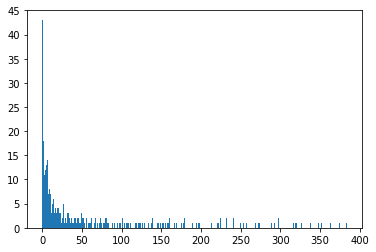

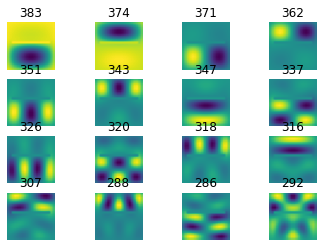

In [108]:
w, v = np.linalg.eig(PC)
plt.figure()
plt.hist(w, bins=400)
plt.ylim([0,45])

fig, axes = plt.subplots(4,4)
for index, ax in enumerate(axes.flat):
    ax.imshow(v[:,index].reshape(20,20))
    ax.set_title(f'{int(np.floor(w[index]))}')
    ax.axis('off')
plt.show()

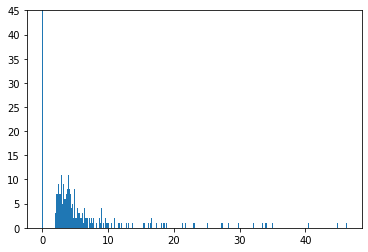

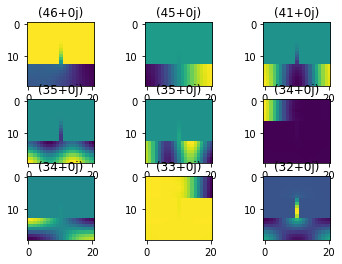

In [27]:
w, v = np.linalg.eig(SR)
plt.hist(w, bins=400)
plt.ylim([0,45])

fig, axes = plt.subplots(3,3)
for index, ax in enumerate(axes.flat):
    ax.imshow(v[:,index].real.reshape(*env.shape))
    ax.set_title(f'{np.round(w[index],0)}')
plt.show()

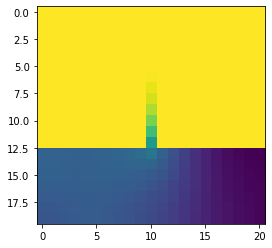

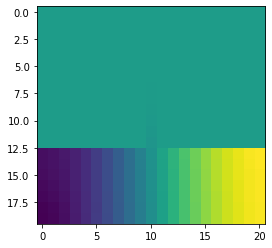

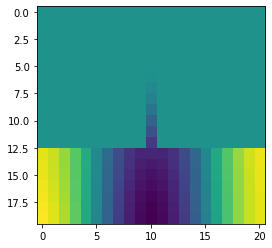

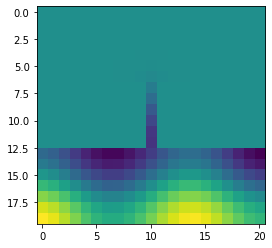

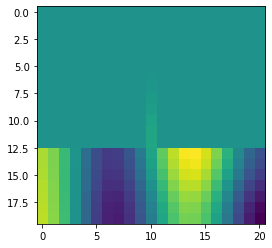

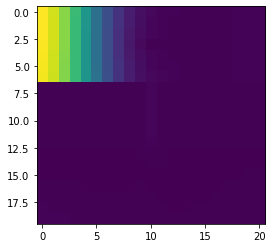

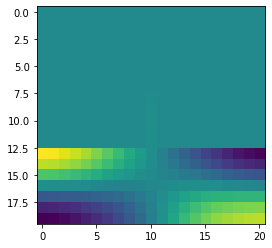

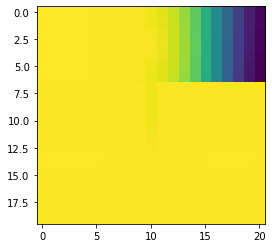

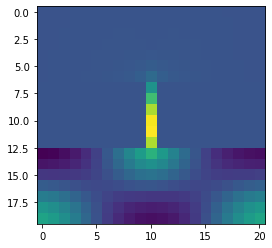

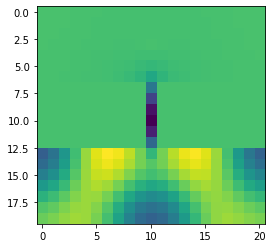

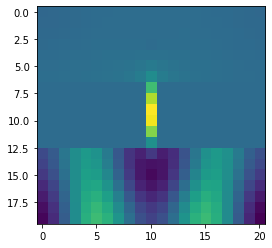

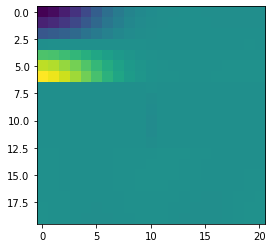

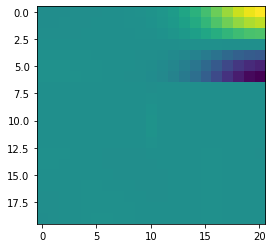

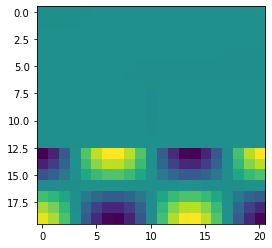

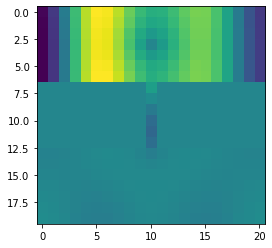

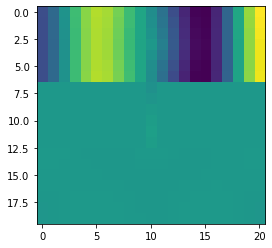

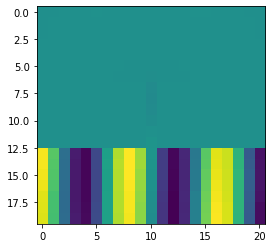

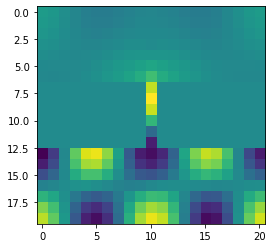

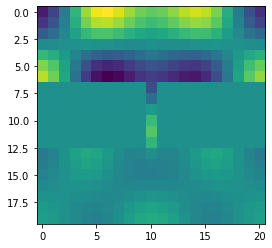

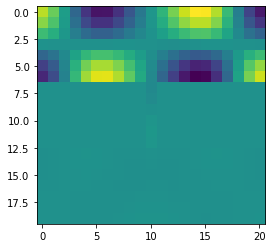

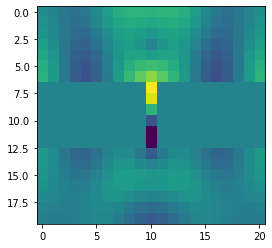

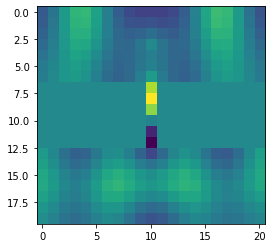

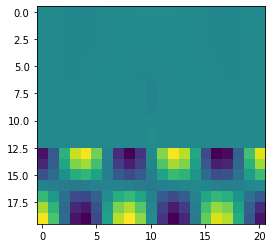

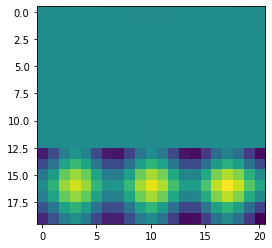

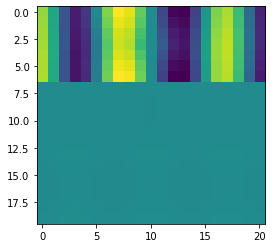

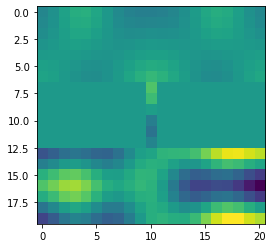

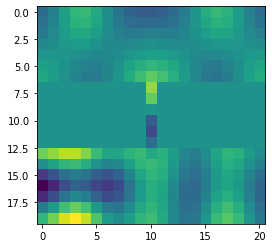

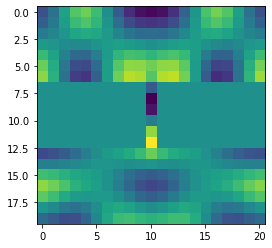

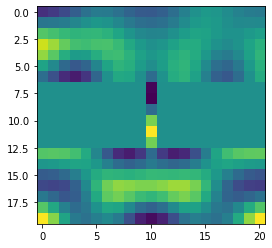

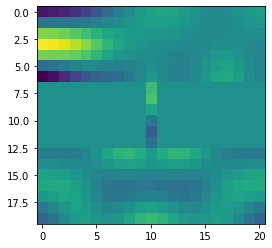

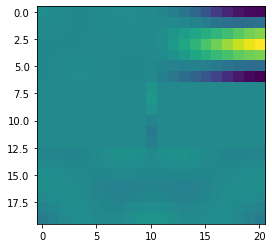

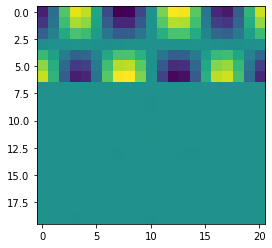

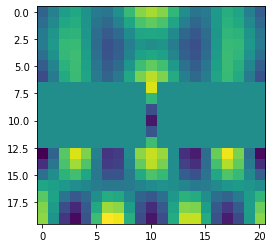

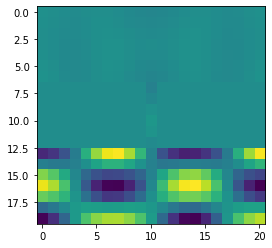

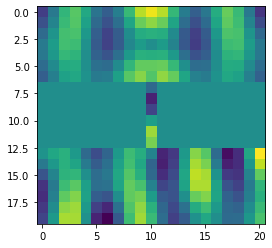

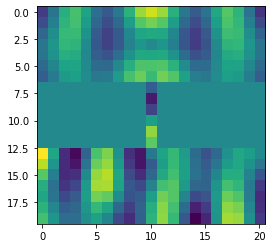

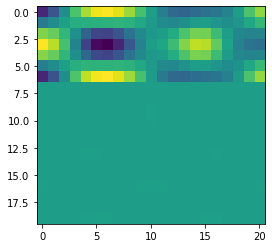

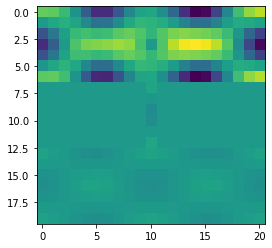

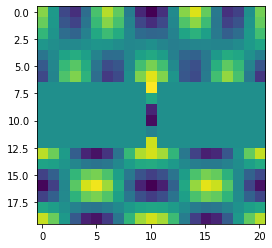

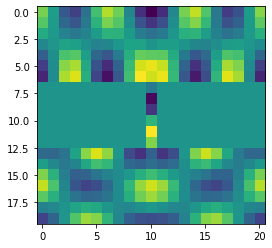

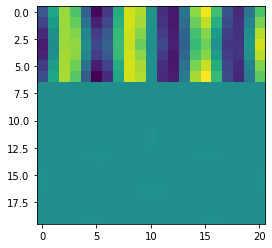

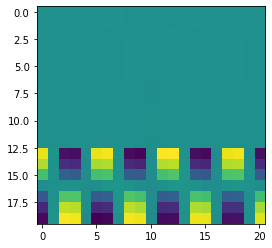

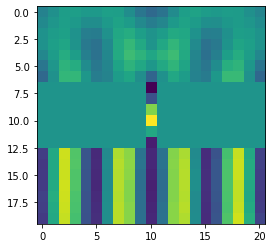

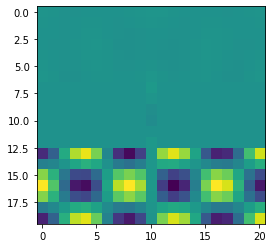

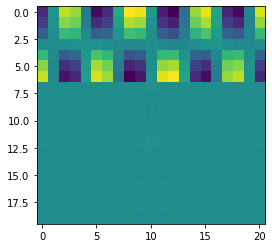

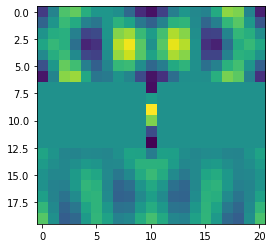

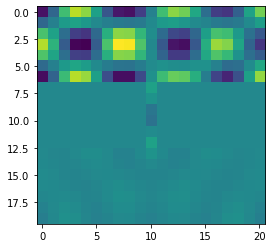

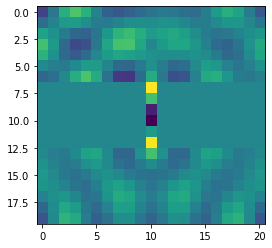

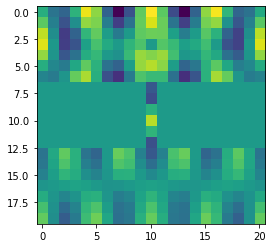

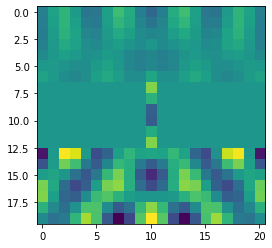

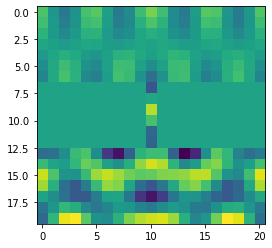

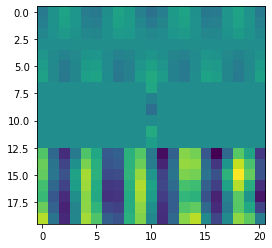

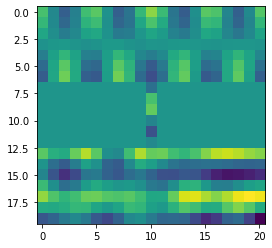

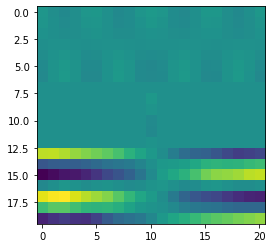

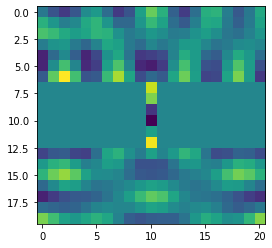

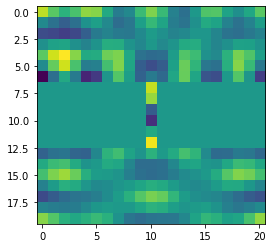

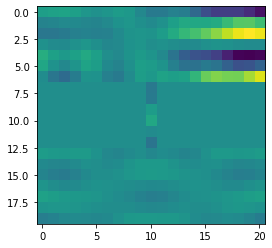

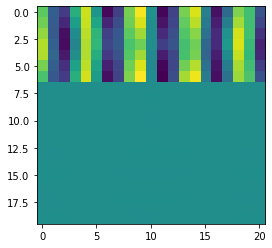

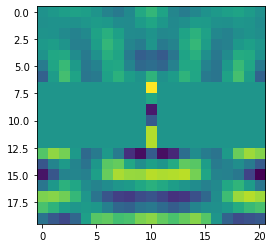

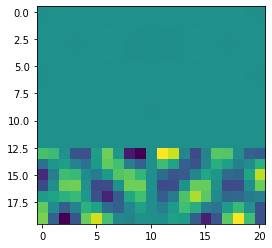

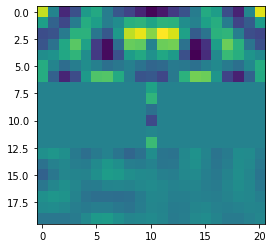

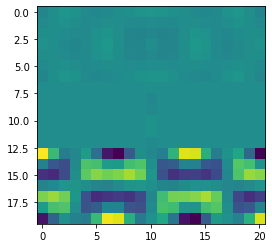

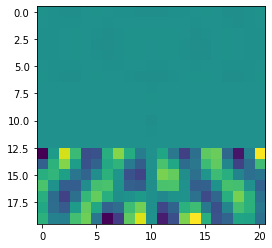

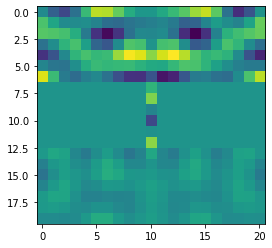

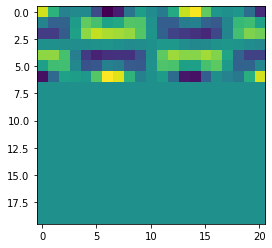

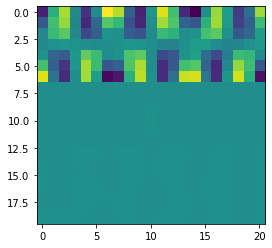

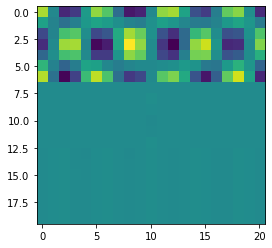

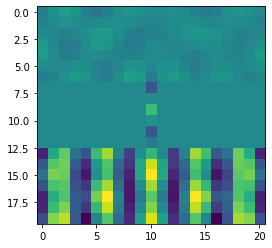

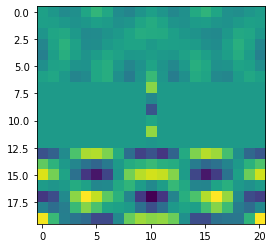

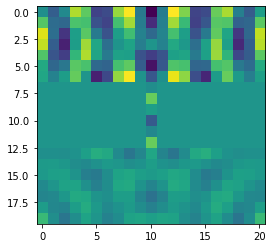

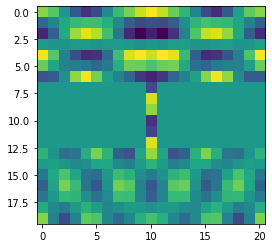

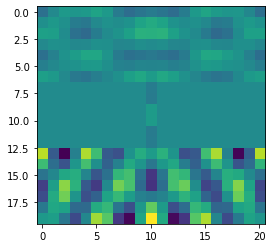

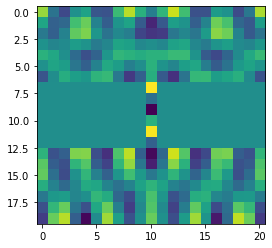

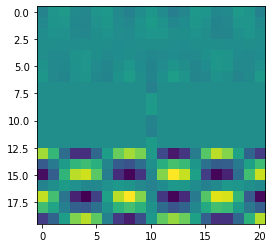

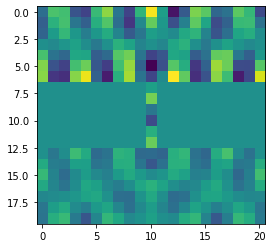

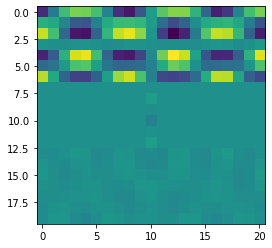

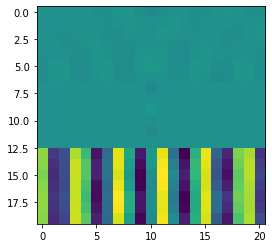

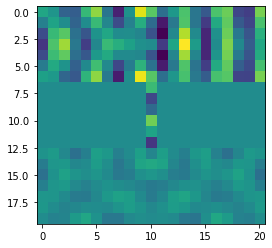

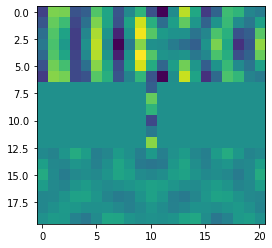

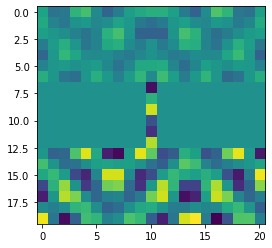

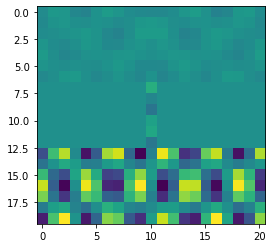

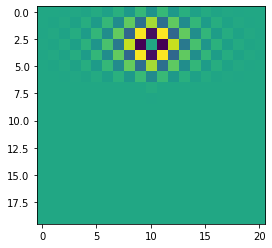

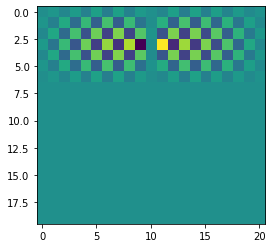

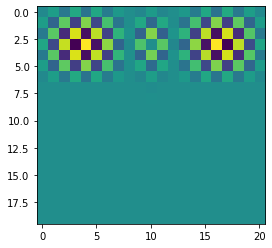

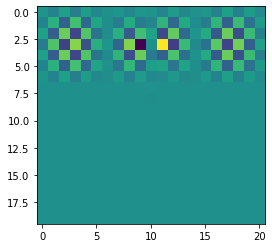

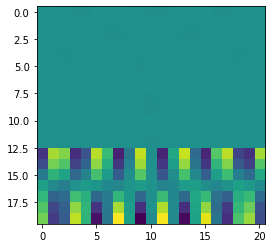

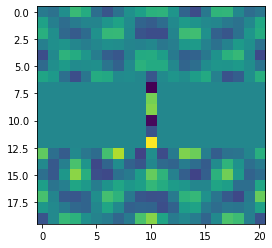

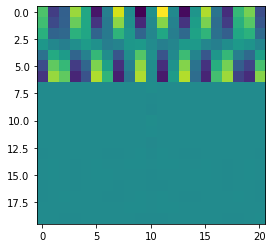

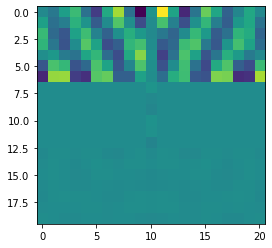

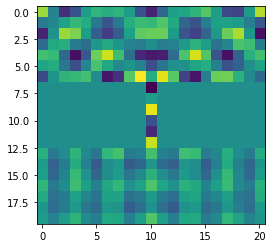

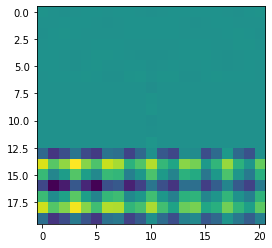

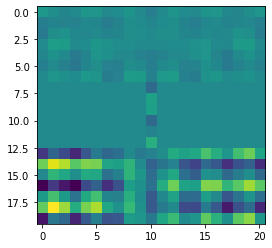

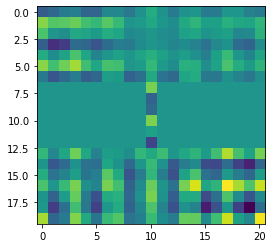

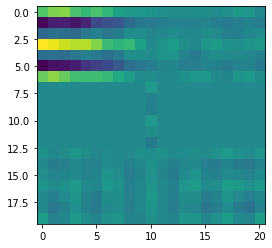

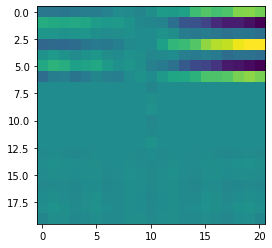

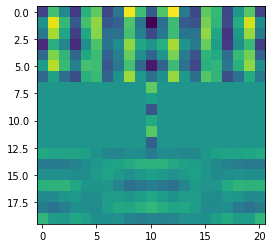

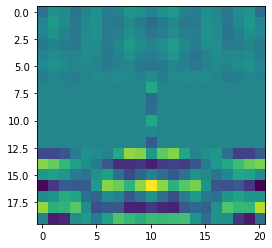

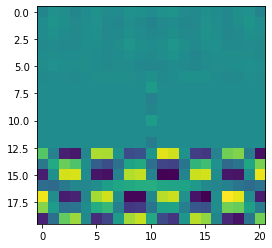

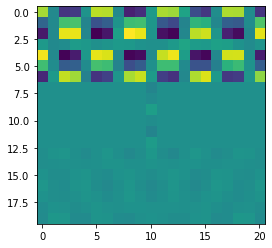

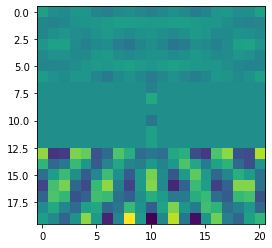

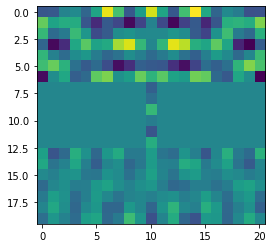

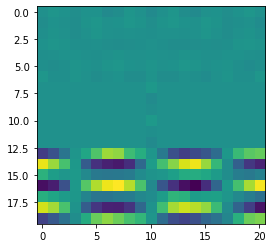

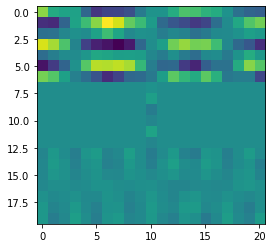

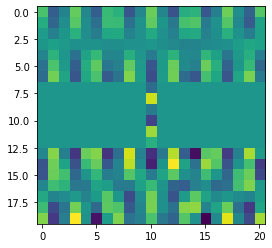

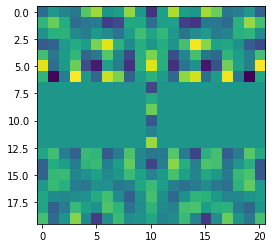

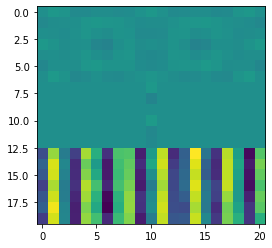

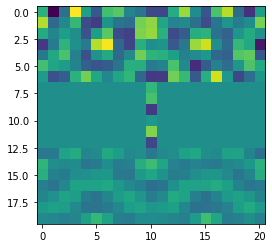

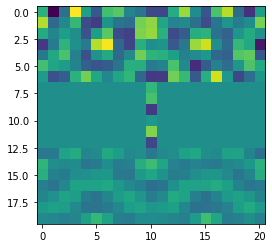

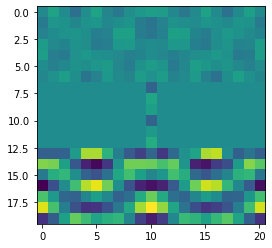

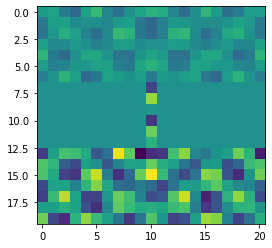

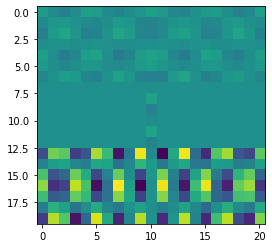

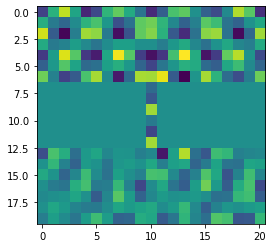

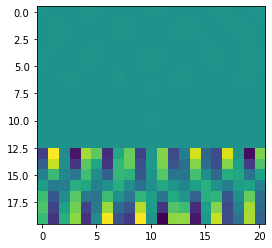

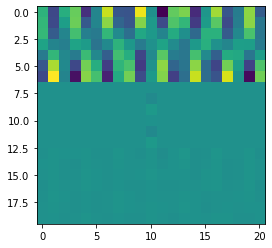

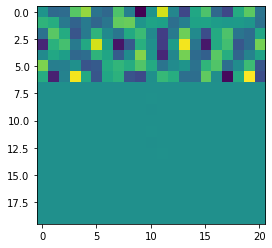

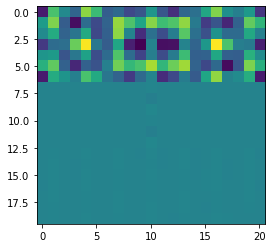

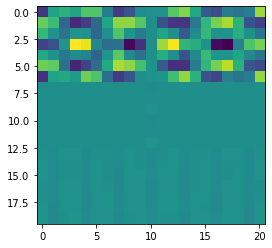

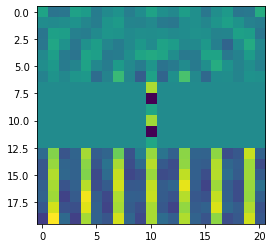

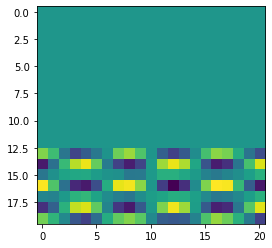

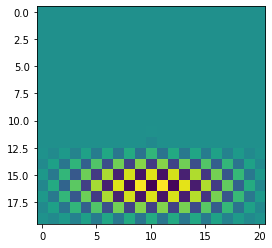

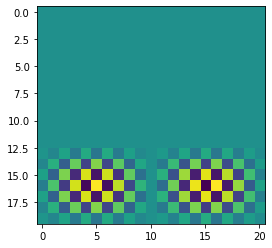

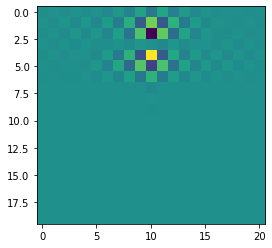

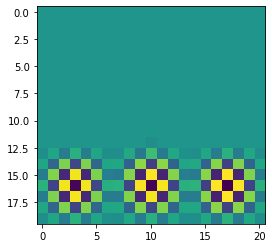

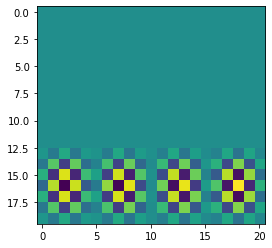

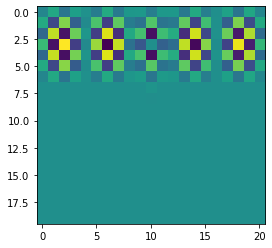

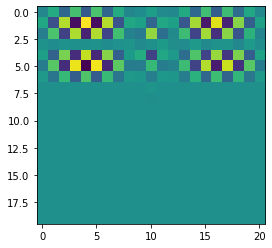

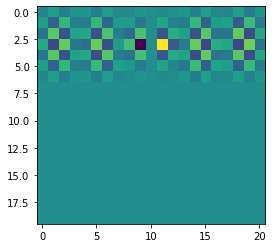

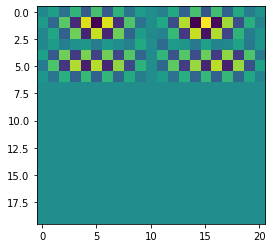

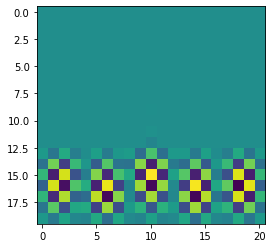

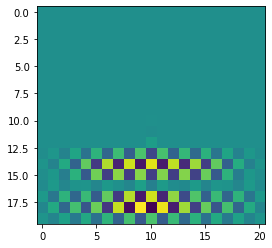

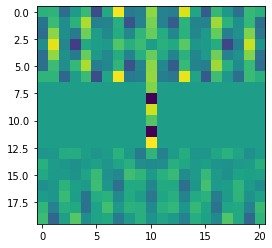

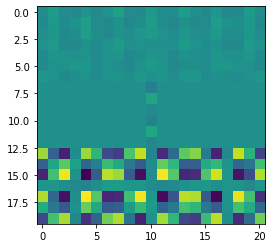

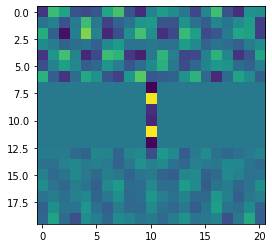

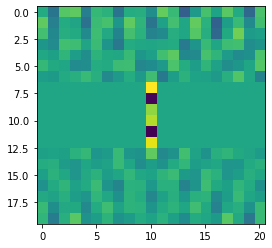

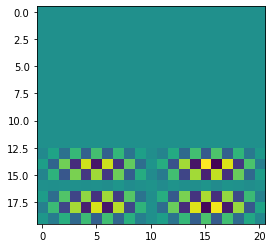

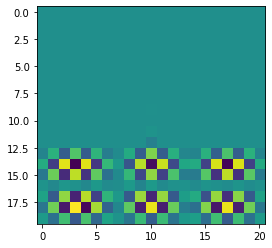

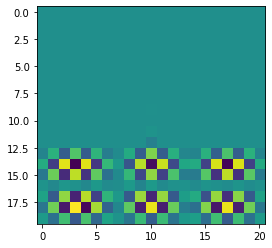

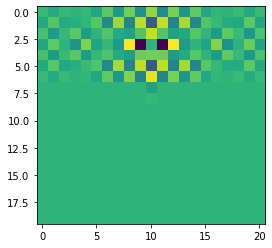

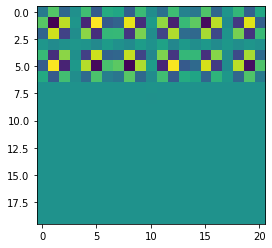

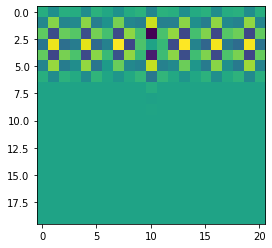

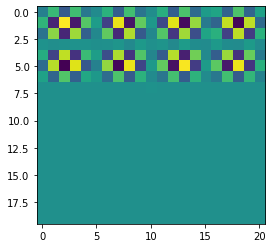

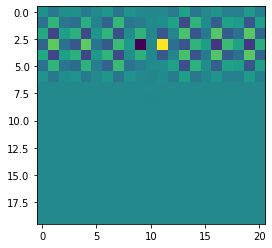

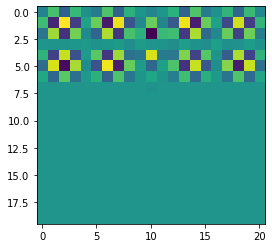

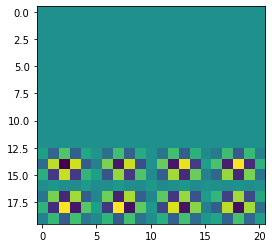

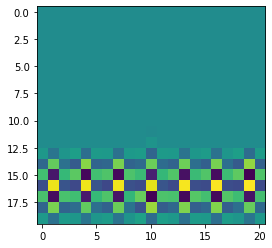

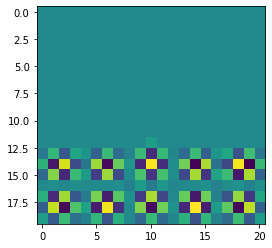

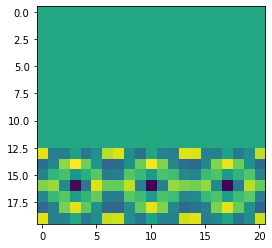

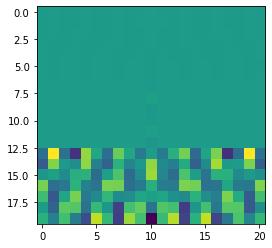

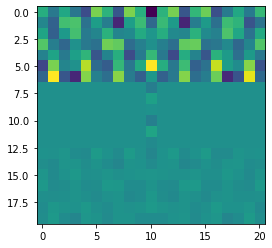

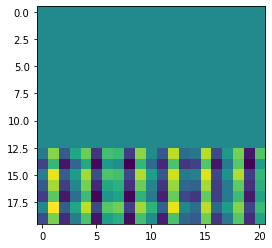

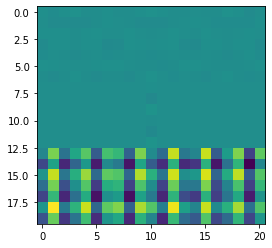

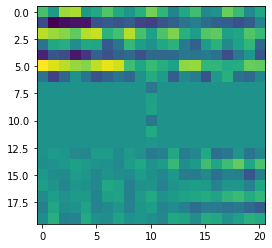

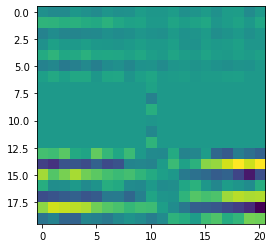

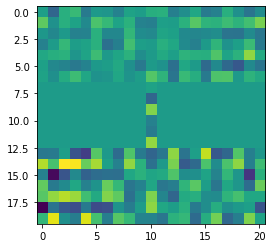

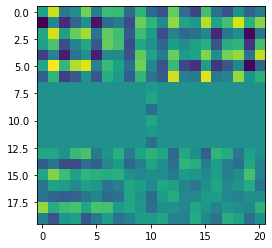

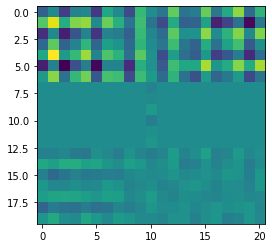

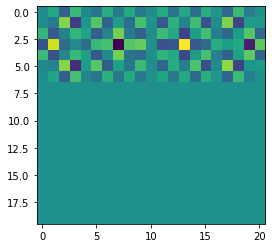

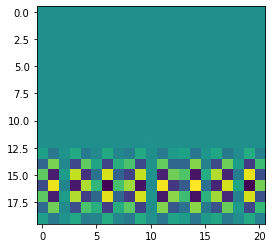

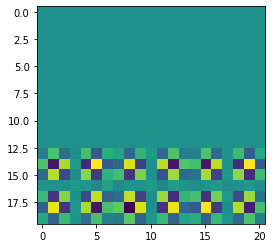

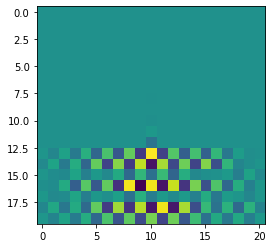

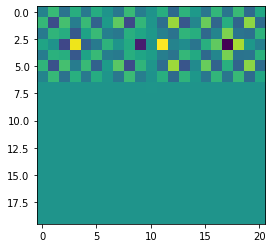

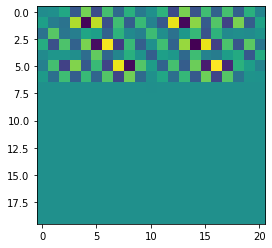

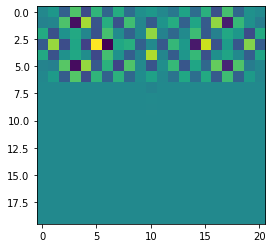

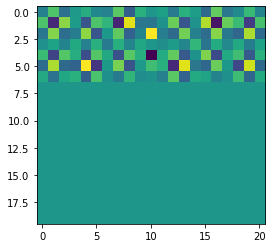

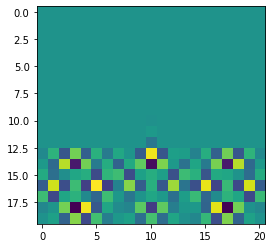

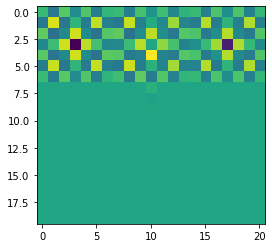

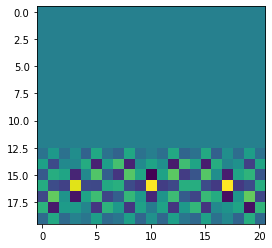

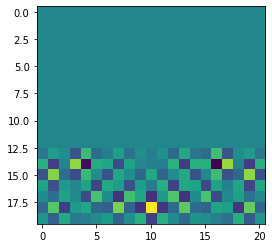

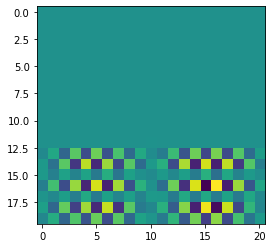

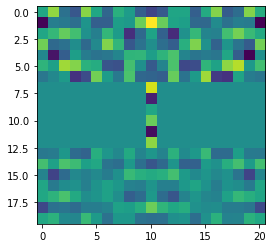

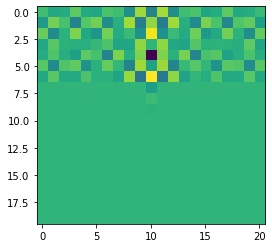

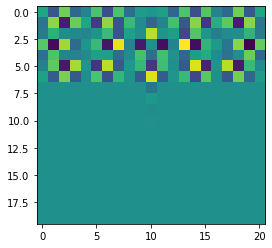

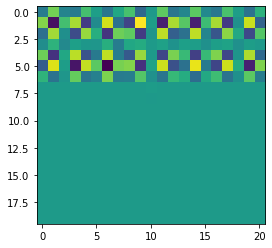

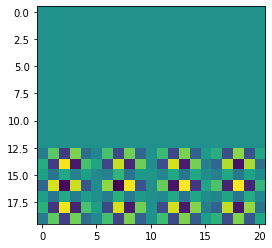

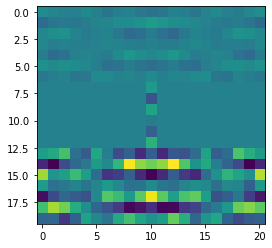

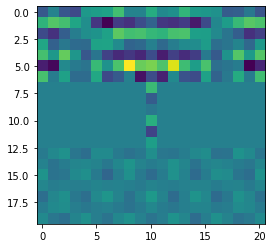

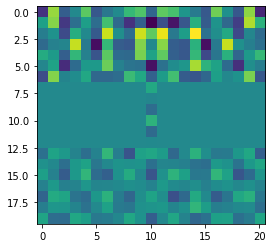

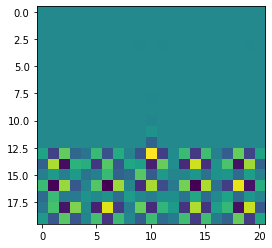

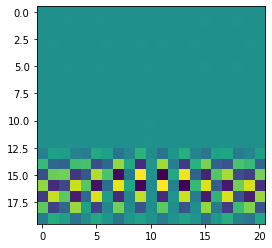

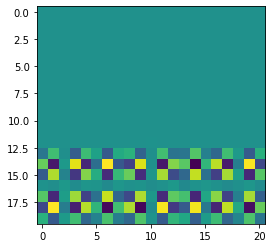

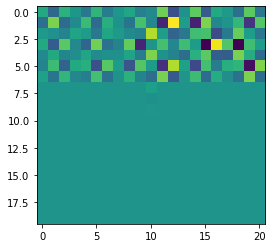

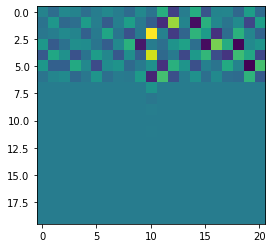

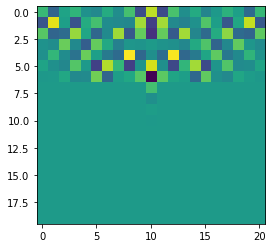

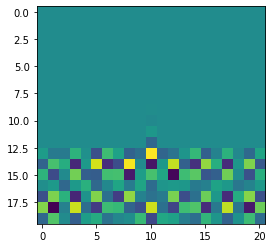

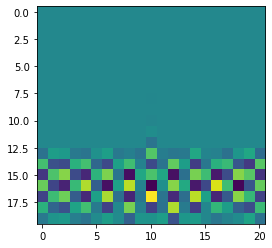

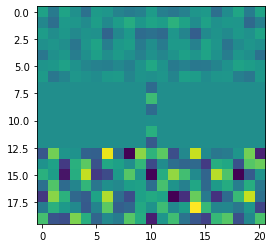

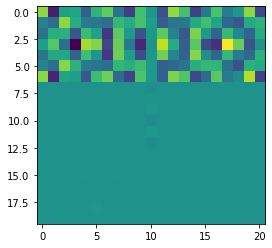

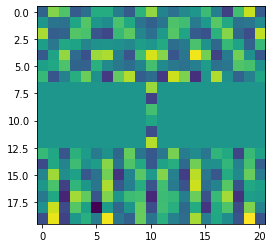

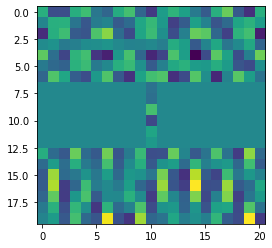

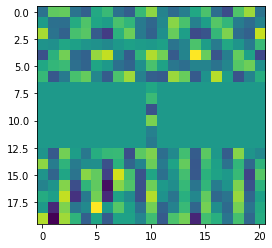

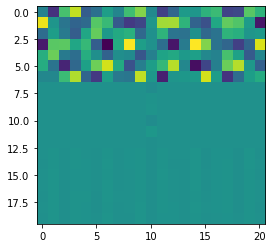

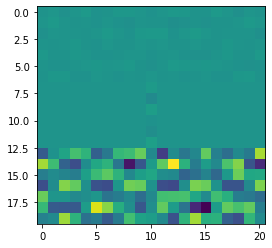

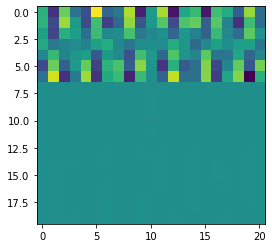

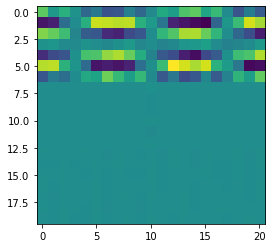

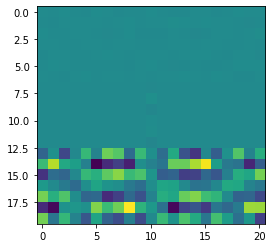

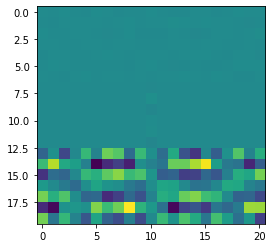

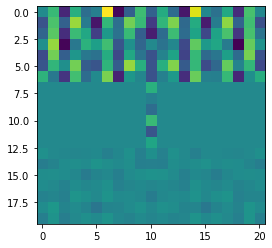

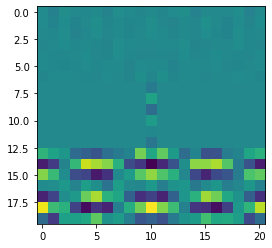

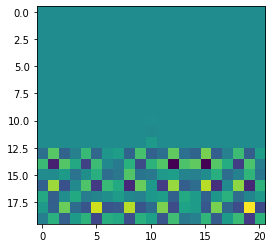

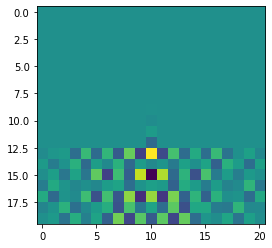

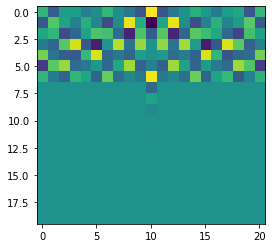

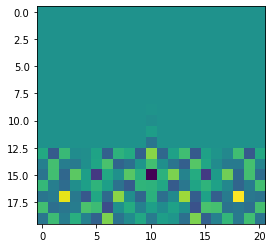

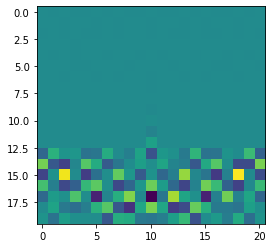

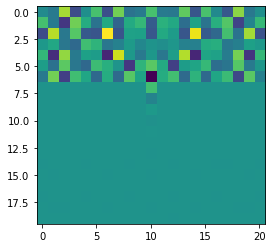

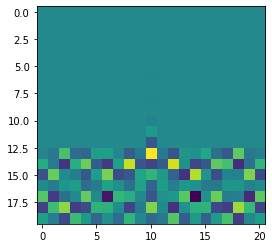

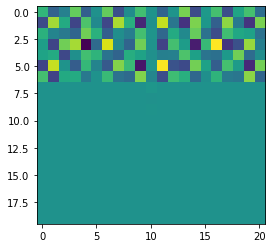

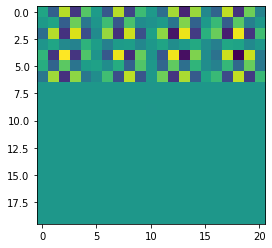

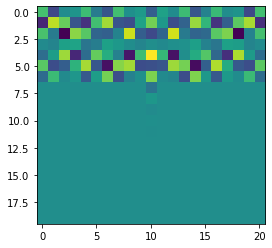

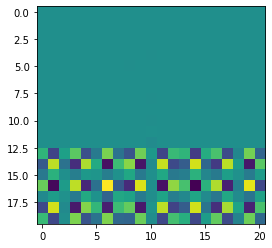

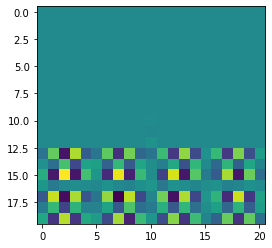

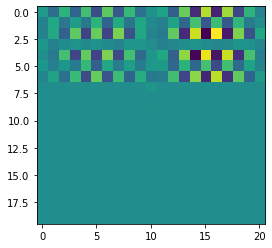

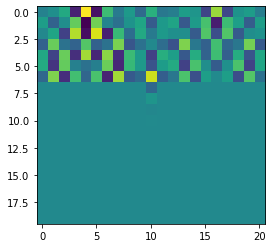

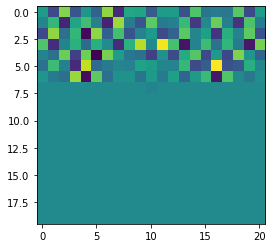

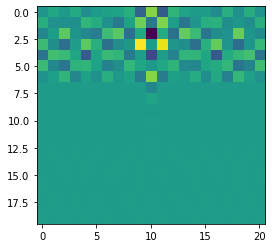

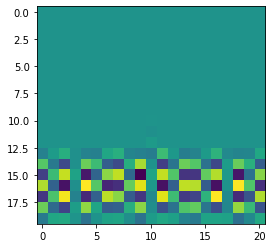

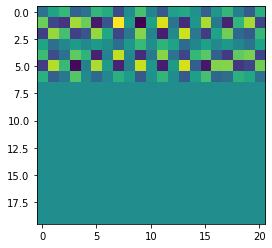

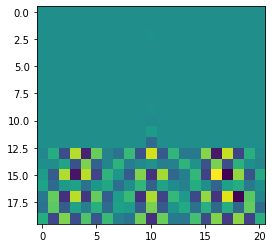

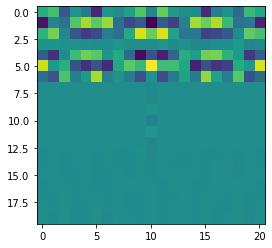

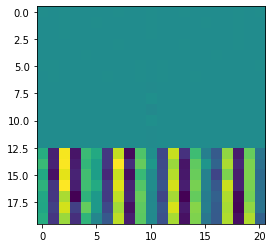

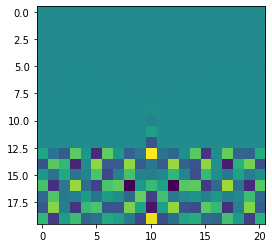

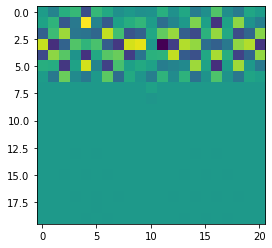

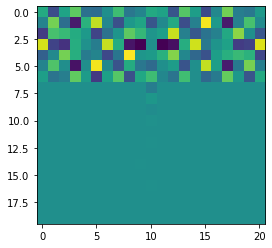

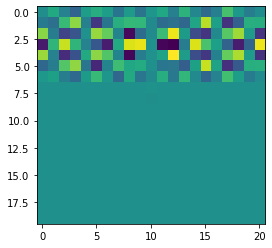

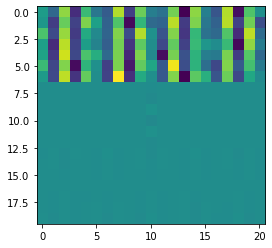

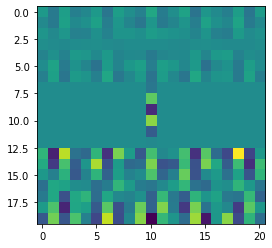

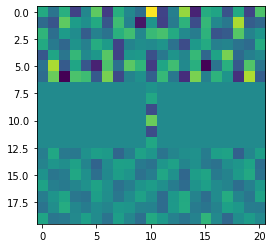

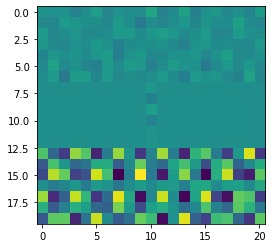

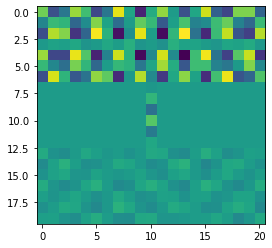

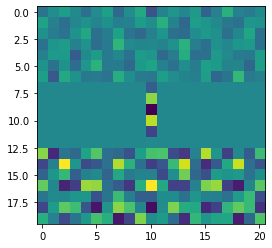

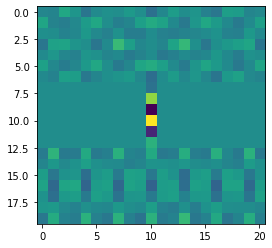

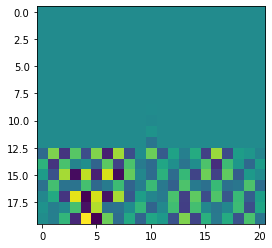

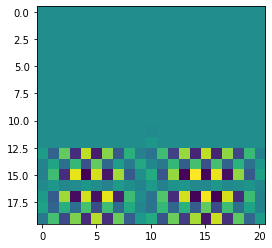

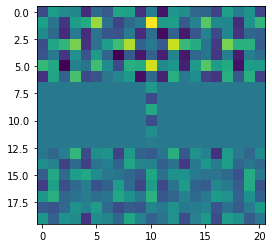

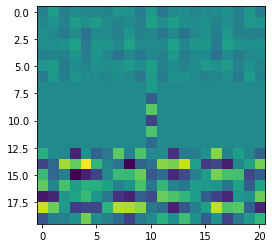

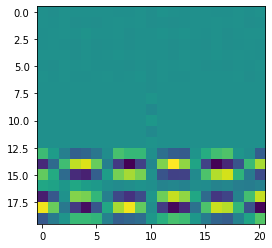

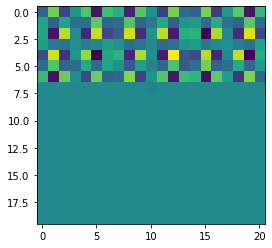

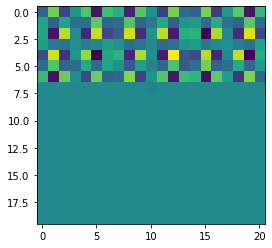

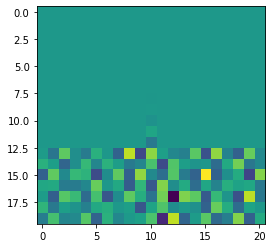

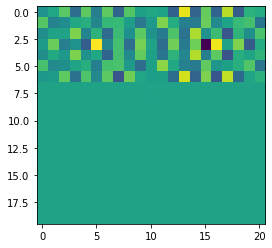

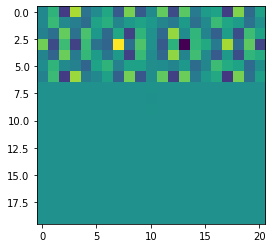

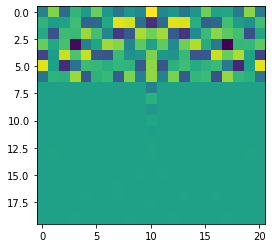

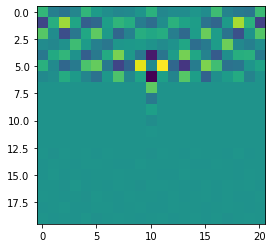

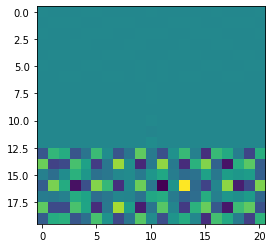

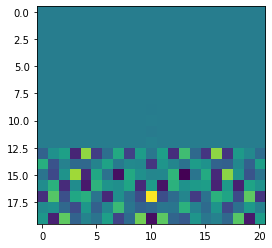

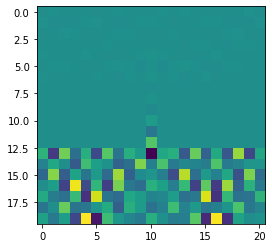

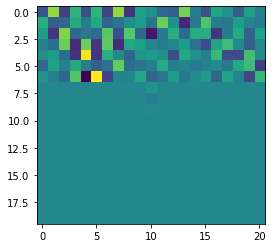

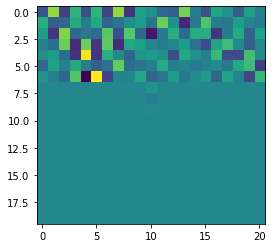

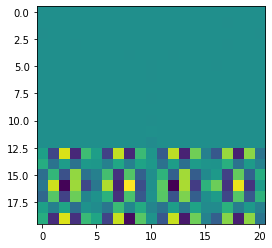

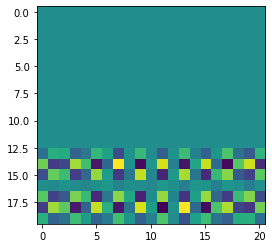

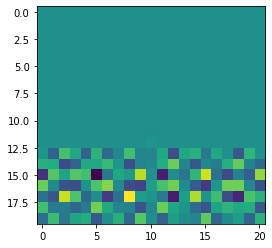

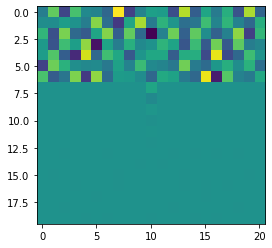

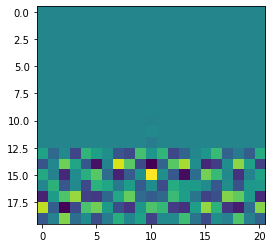

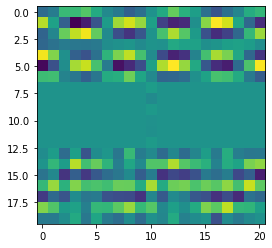

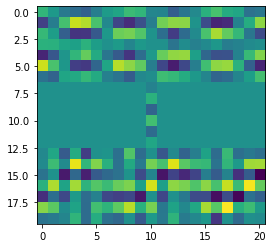

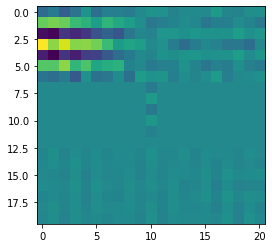

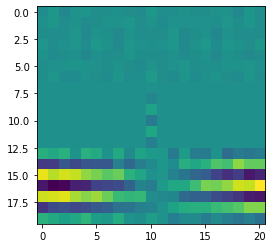

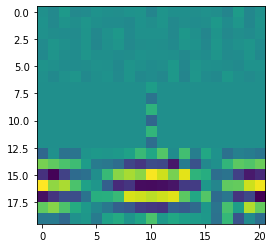

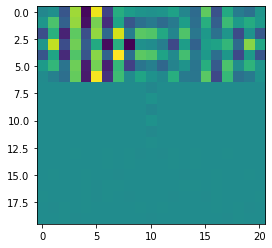

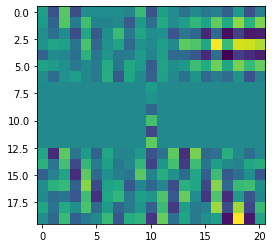

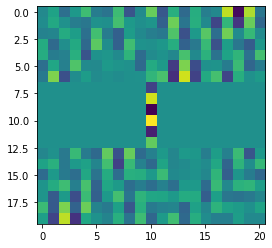

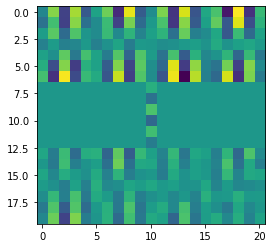

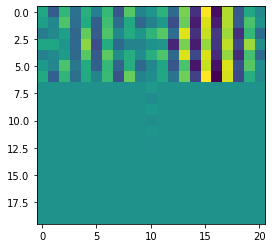

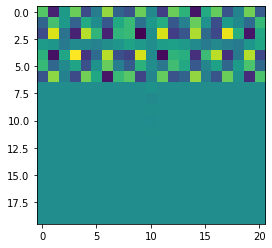

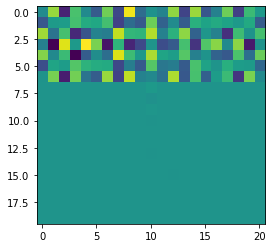

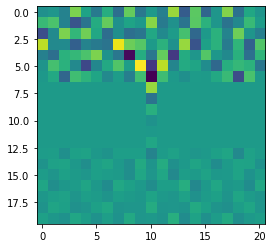

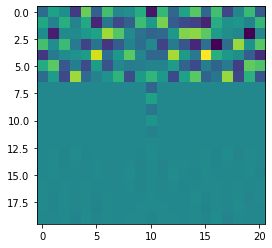

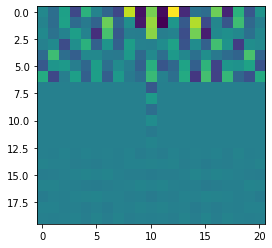

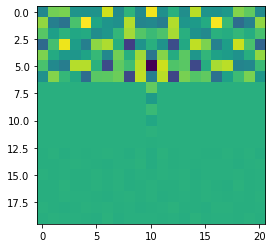

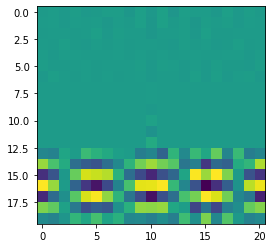

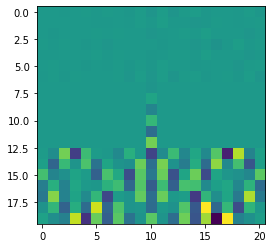

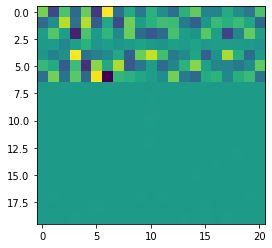

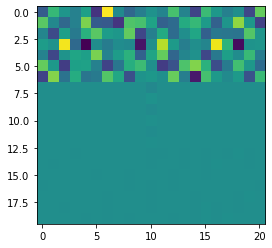

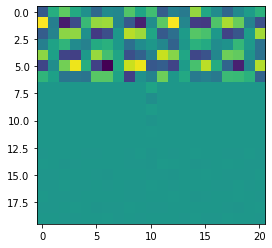

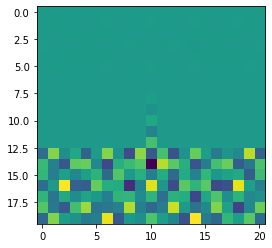

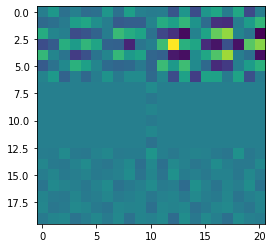

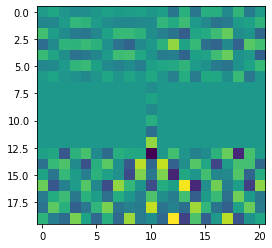

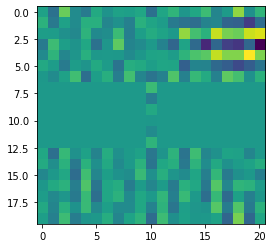

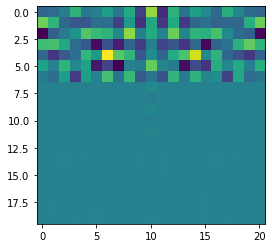

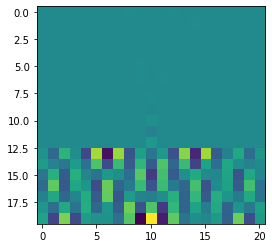

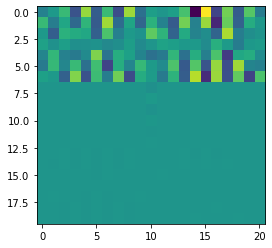

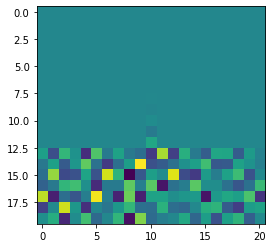

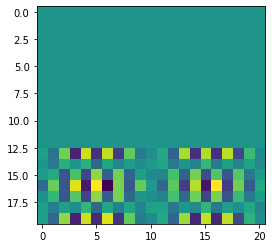

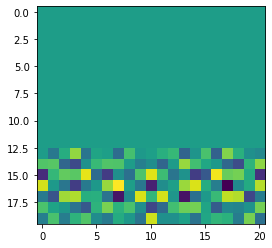

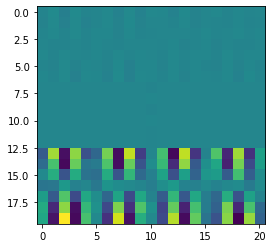

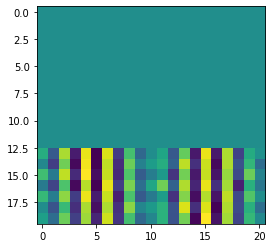

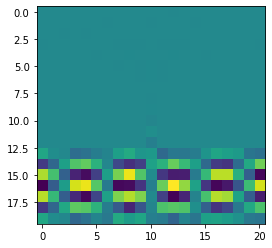

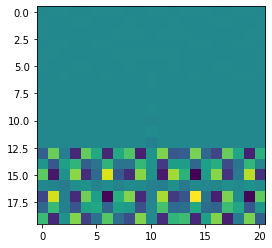

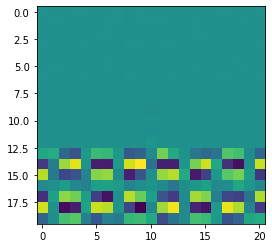

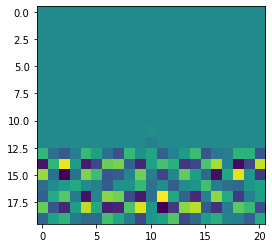

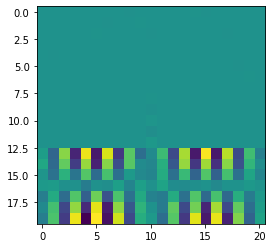

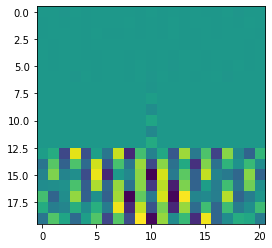

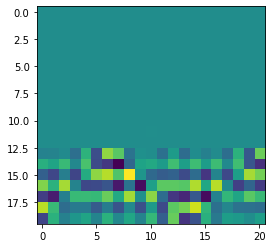

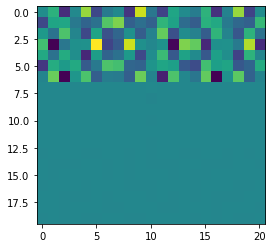

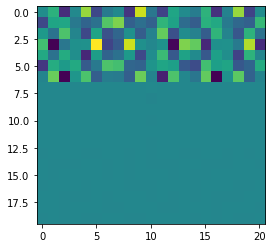

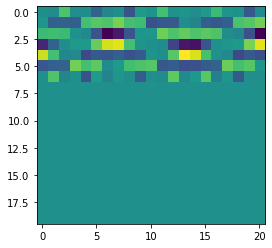

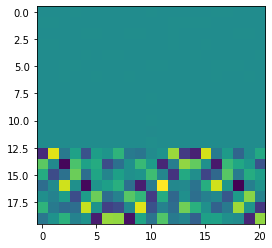

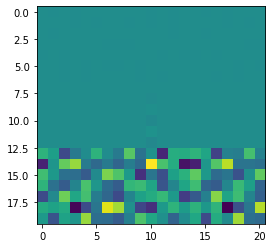

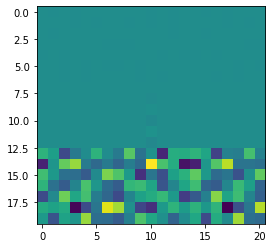

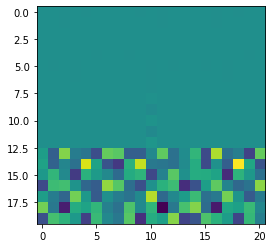

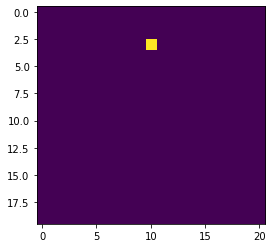

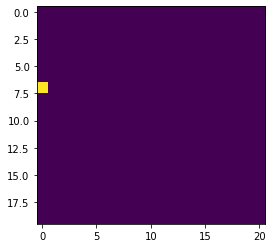

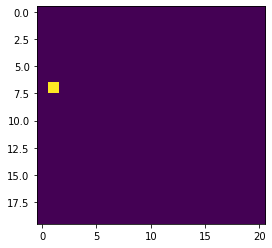

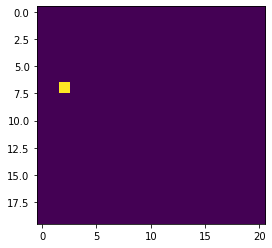

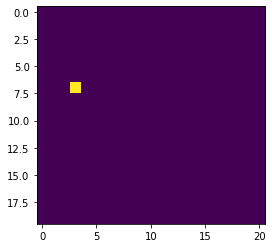

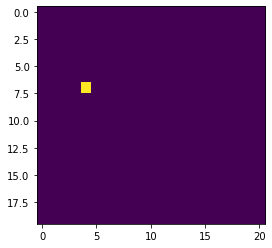

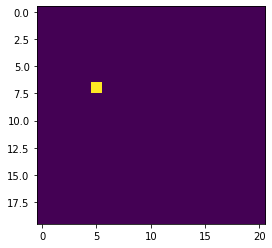

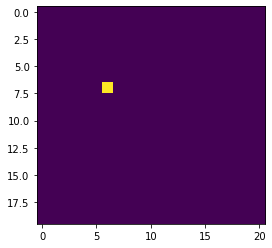

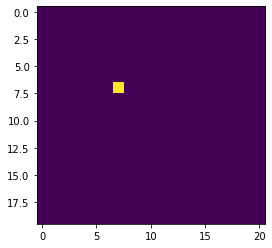

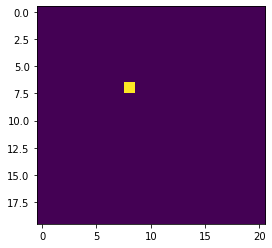

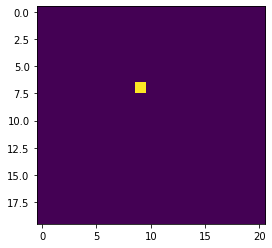

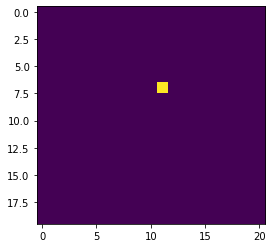

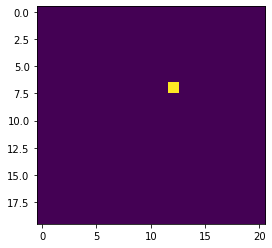

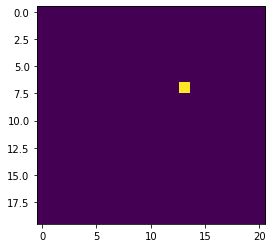

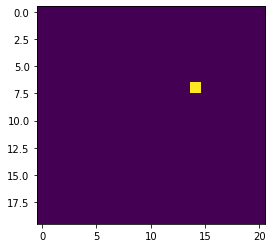

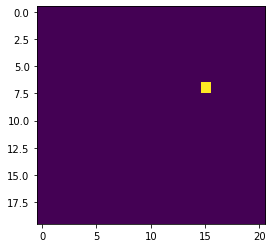

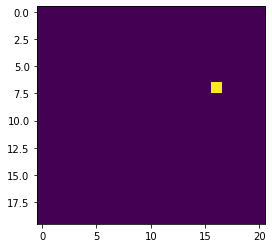

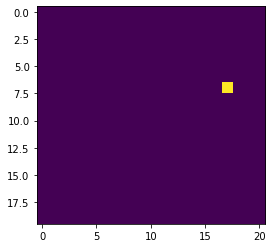

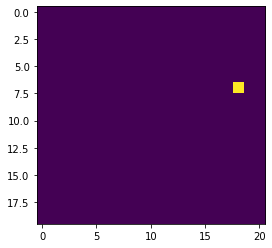

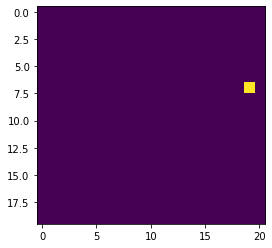

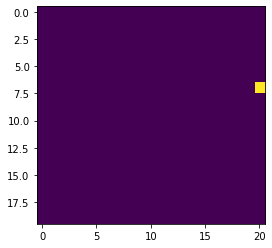

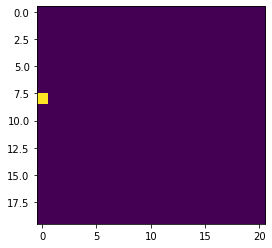

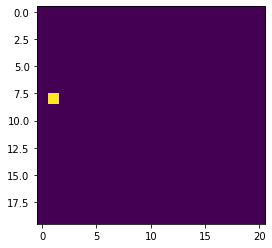

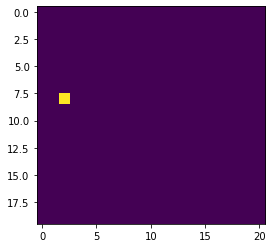

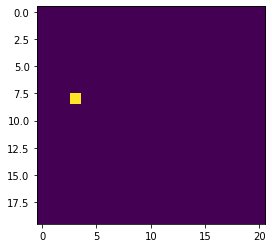

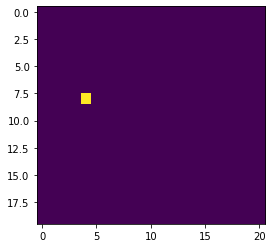

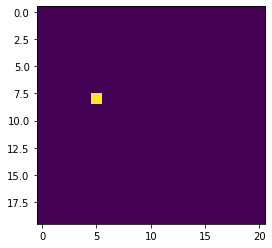

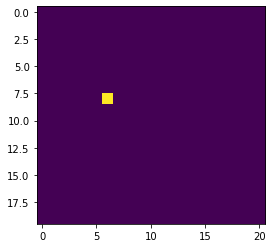

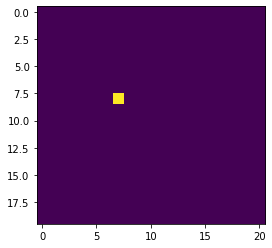

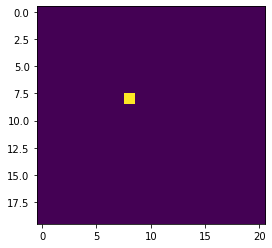

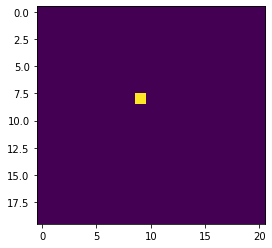

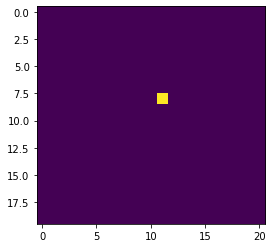

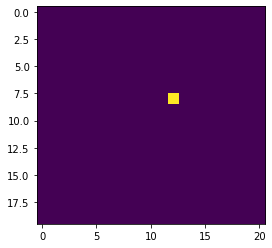

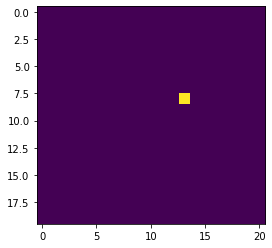

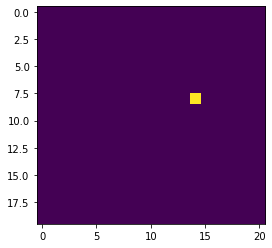

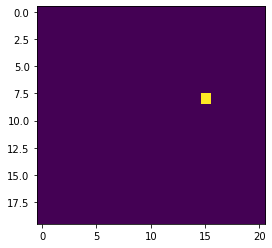

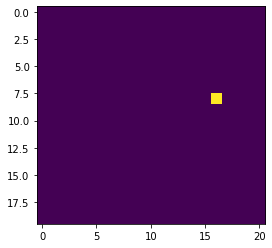

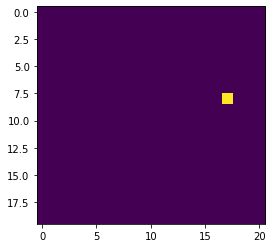

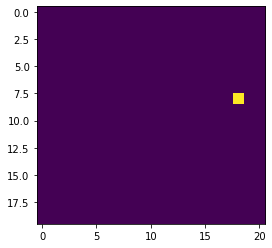

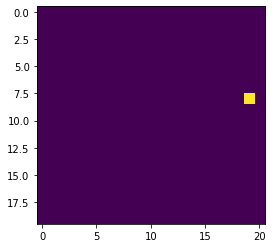

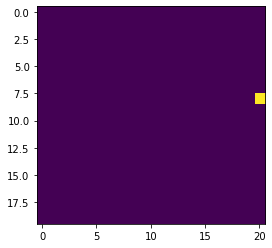

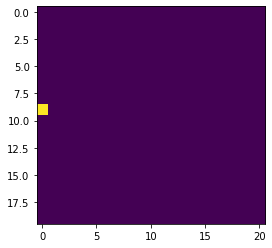

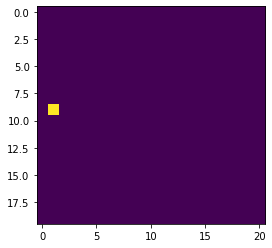

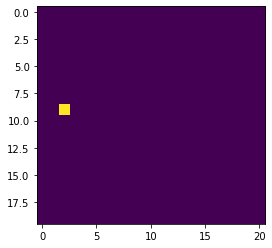

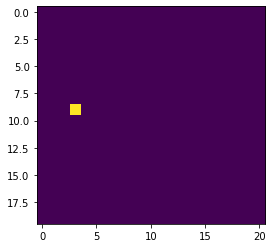

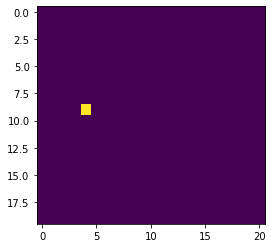

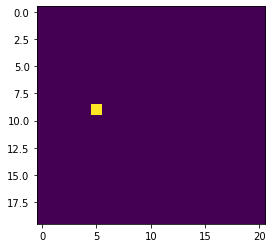

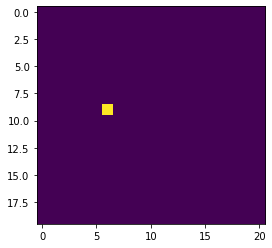

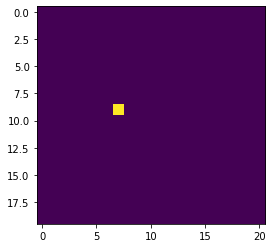

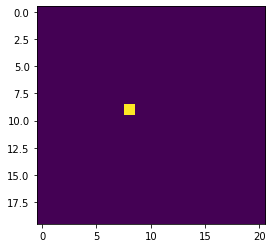

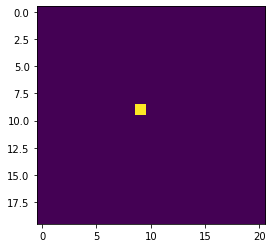

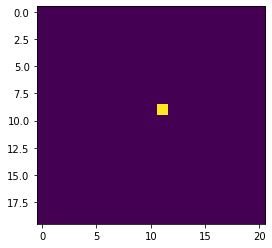

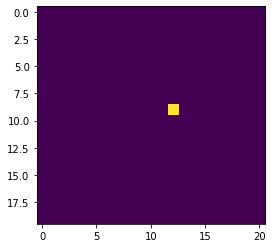

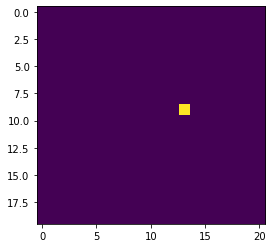

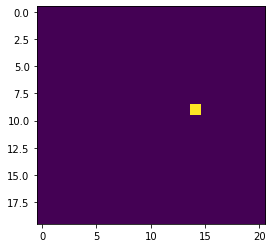

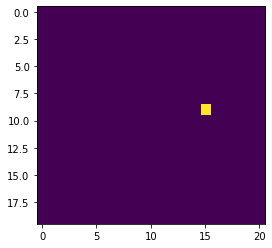

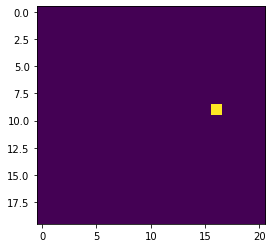

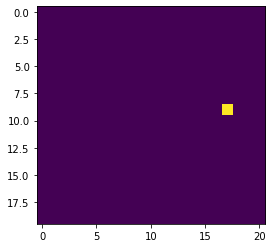

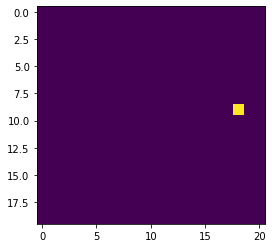

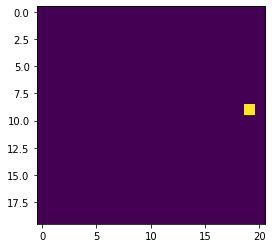

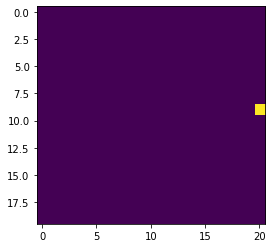

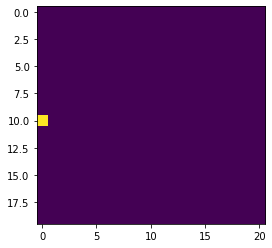

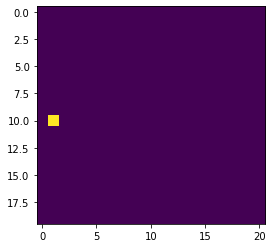

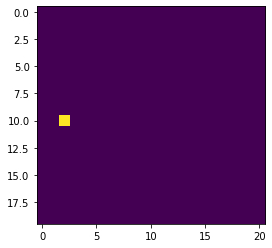

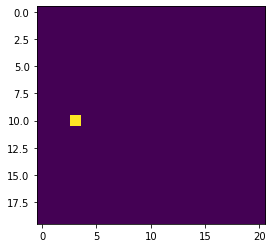

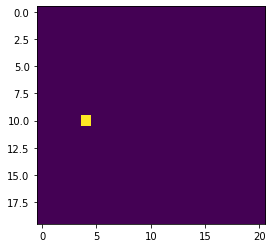

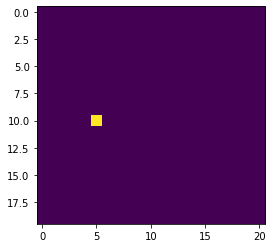

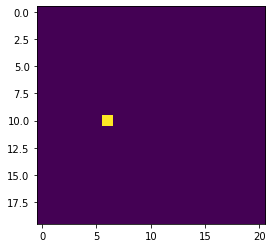

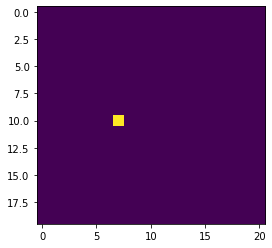

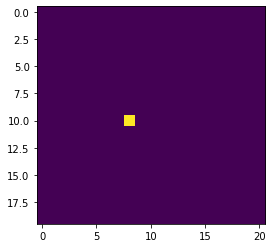

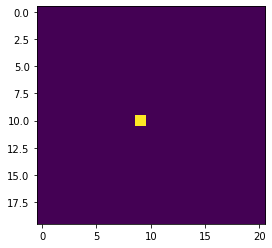

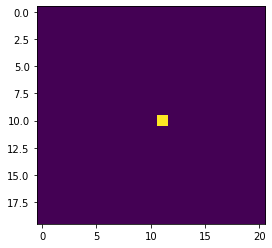

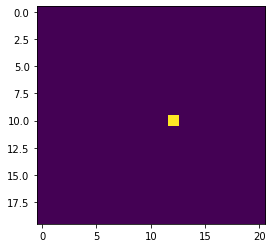

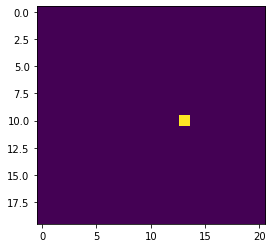

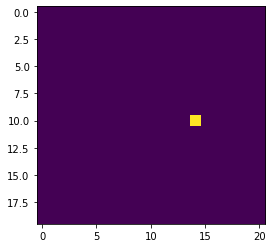

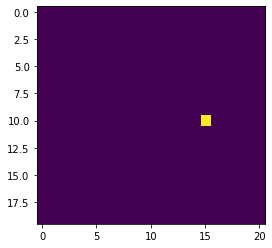

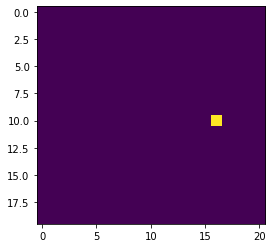

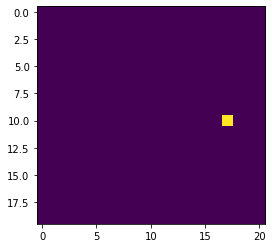

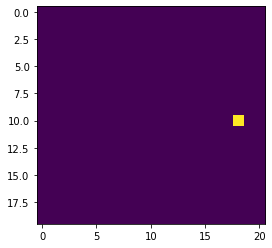

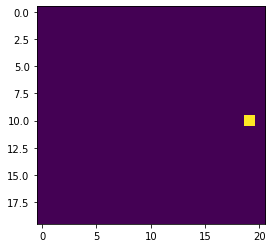

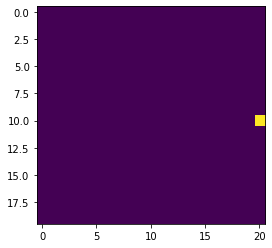

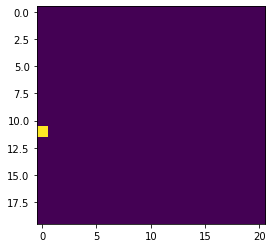

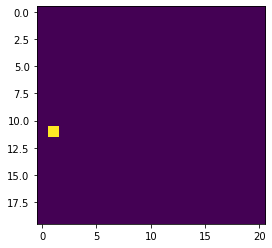

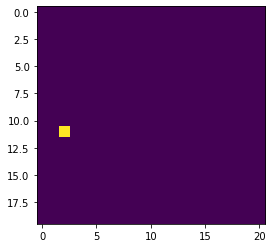

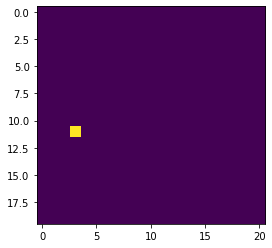

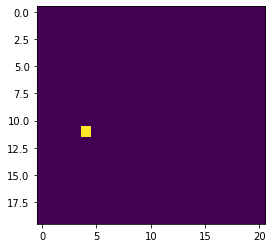

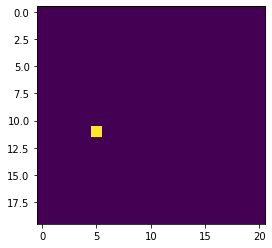

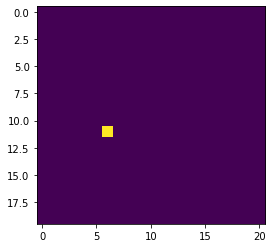

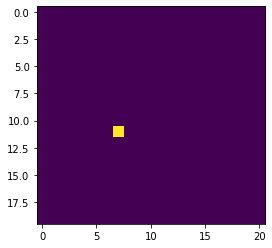

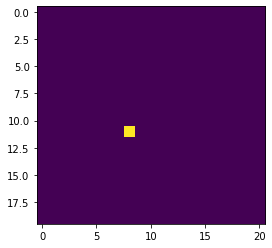

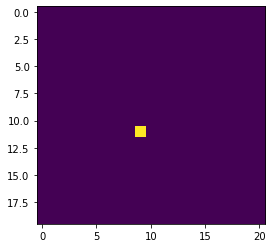

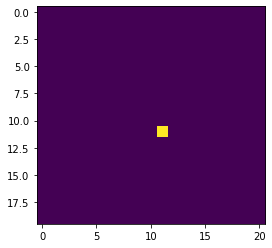

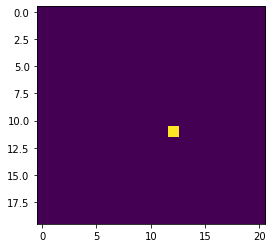

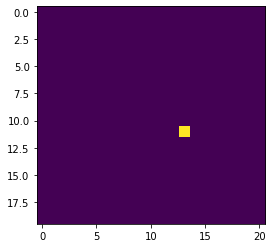

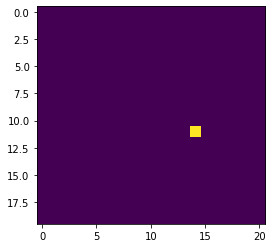

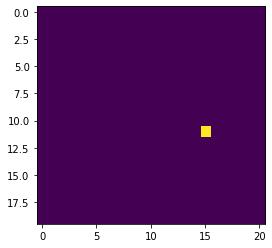

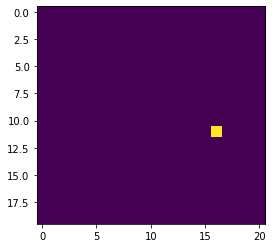

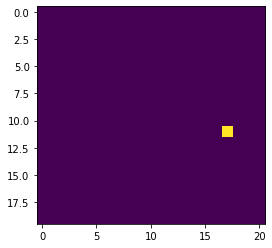

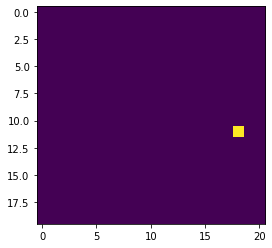

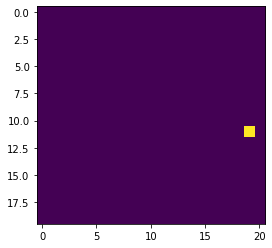

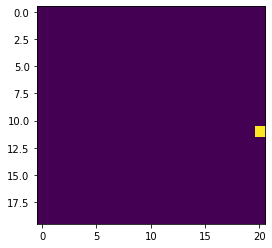

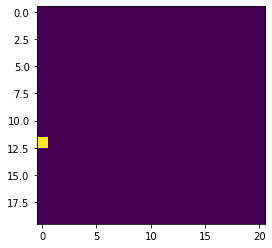

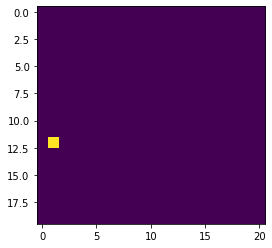

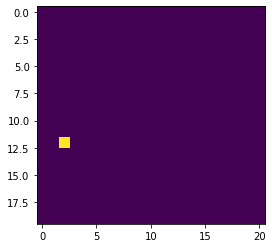

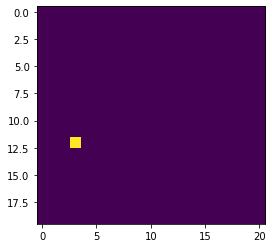

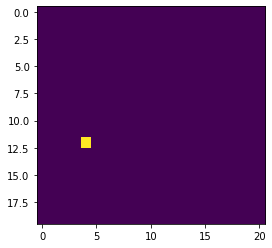

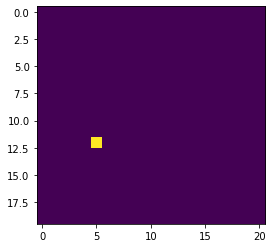

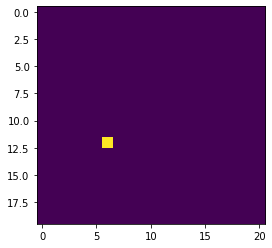

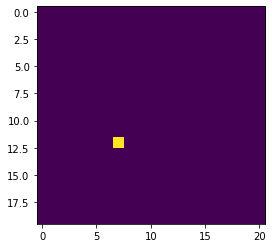

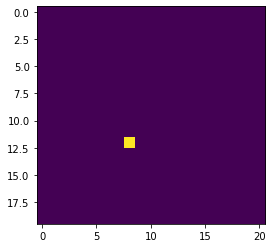

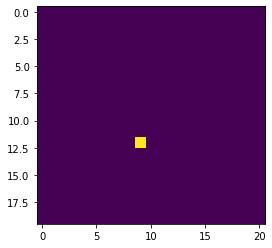

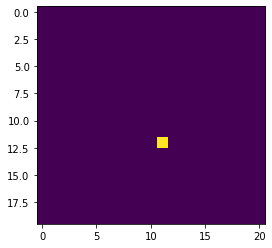

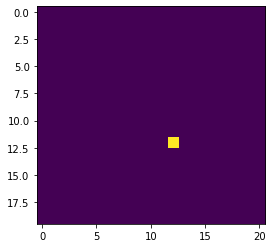

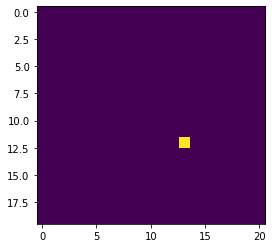

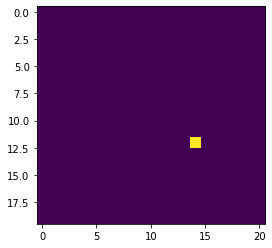

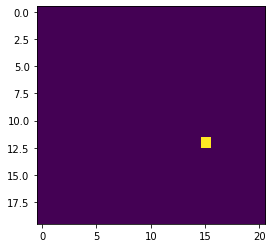

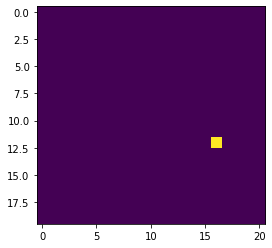

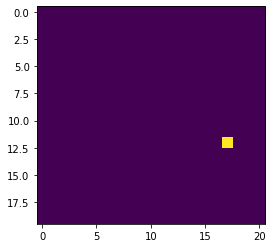

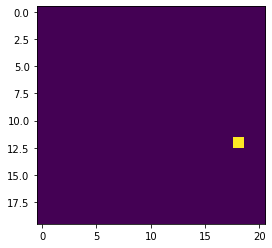

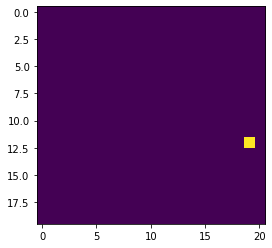

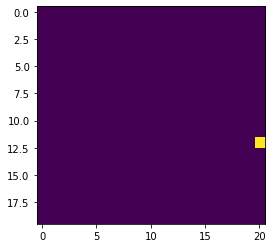

In [28]:
for ind in range(v.shape[0]):
    plt.figure()
    plt.imshow(v[:,ind].real.reshape(*env.shape))
    plt.show()

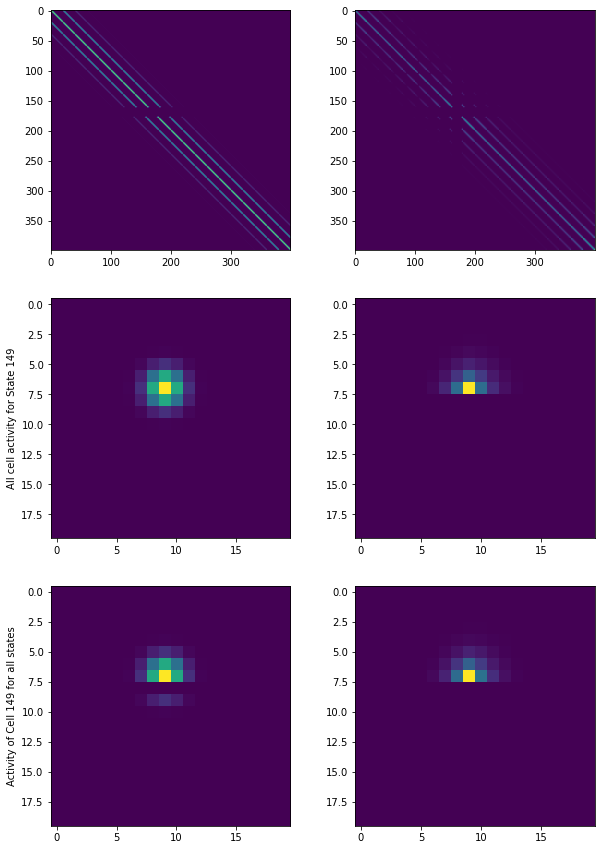

In [81]:
state_of_interest = 149
nrows = 3
ncols = 2

fig, ax = plt.subplots(nrows,ncols, figsize=(10,15))
# get activities for that state
ax[0,0].imshow(PC)
ax[0,1].imshow(SR)

ax[1,0].imshow(PC[state_of_interest].reshape(*env.shape)) # PC
ax[1,0].set_ylabel(f'All cell activity for State {state_of_interest}')
ax[1,1].imshow(SR[state_of_interest].reshape(*env.shape)) # SR

ax[2,0].imshow(PC[:,state_of_interest].reshape(*env.shape)) # PC
ax[2,0].set_ylabel(f'Activity of Cell {state_of_interest} for all states')
ax[2,1].imshow(SR[:,state_of_interest].reshape(*env.shape)) # SR


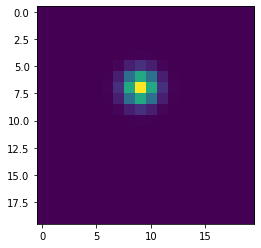

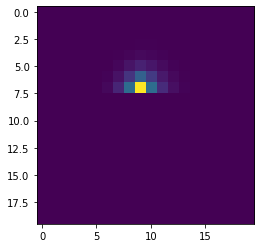

In [84]:
plt.figure()
plt.imshow(PC[state_of_interest].reshape(*env.shape)) # PC

plt.figure()
plt.imshow(SR[state_of_interest].reshape(*env.shape)) # SR